In [2]:
!pip install wand

!apt install imagemagick

!pip install myqlm

!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 KB 14.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texliv

## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [1]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:

    val = 0
    for edge in edges:
      i, j = edge
      a1 = 2*b[i] - 1
      a2 = 2*b[j] - 1
      val += a1*a2
      
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

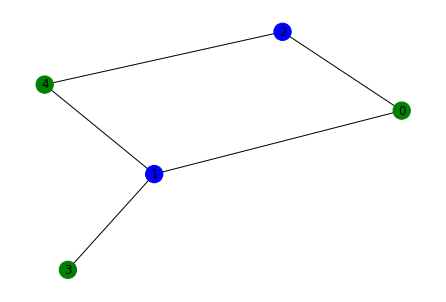

In [2]:
# Je me suis permis d'ajouter des couleurs pour gagner en visibilité
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for i,j in edges:
    G.add_edge(i,j)


color_map = []
for node in G:
    if best_b[node] ==0:
        color_map.append('blue')
    else: 
        color_map.append('green')      
        
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

In [3]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [4]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()
    #TODO: implement one qaoa layer

    # Première couche de portes RX
    for k in range(n_qubits):
      layer.apply(RX(theta), k)
  
    # Seconde couche avec la fonction coût
    for (i,j) in edges:
      layer.apply(U_ZZ(beta), i, j)
    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit

    for k in range(n_qubits): # phase d'initialisation avec la tourelle d'Hadamard
      prog.apply(H, qubits[k])

    for k in range(n_layers): # portes QAOA
      theta = parameters[2*k]
      beta = parameters[2*k + 1]
      prog.apply(one_qaoa_layer(n_qubits, edges, theta, beta), qubits)
    
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO

    obs = 0
    for sample in result:
        # boucle sur les 2 ** nqubits états
        # sample.state.bitstring contient les valeurs des qubits 
        val = 0
        b = [int(i) * 2 - 1 for i in sample.state.bitstring] # transforme le string sample.state.bitstring en valeur {+1, -1}
        
        for edge in edges:
          i, j = edge
          val += b[i] * b[j]
        obs += val * sample.probability # calcule la moyenne des observables

    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.21898603, 0.27758779, 0.6469886 ])

In [8]:
from scipy.optimize import minimize

### Random initialisation

### Question 5: 
réponse à la question:

3
4
5


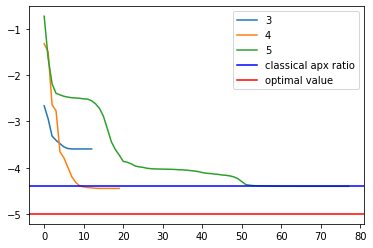

In [16]:
import matplotlib.pylab as plt


for nlayers in range(3,6,1):
    num_params = 2*nlayers
    print(nlayers)

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

Using adiabatic quantum computing method, we are going to initiate the parameters to generate the following evolution :

$$ exp\left(i\int_0^T H(s)ds\right) = \prod_{k=0}^{p-1}exp\left(-i(1-\frac{k}{p})\Delta t \times H_B\right) \times exp\left(-i \frac{k}{p} \Delta t \times H_C\right) $$ 

where $ \Delta t = T/p$.

This yields $\theta_k = (1-\frac{k}{p})*\Delta t$ and $\beta_k = \frac{k}{p} * \Delta t$.

3
4
5


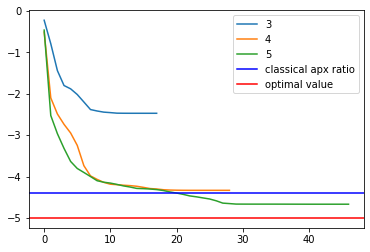

In [15]:
T = 1.

for nlayers in range(3,6,1):
    print(nlayers)

    num_params = 2*nlayers
    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        #print(eva, end=' ')

    # TODO implement parameter init

    delta_t = T / nlayers # pas de temps
    parameters_init = []
    for k in range(nlayers):
      parameters_init.append((1 - k / nlayers) * delta_t) # theta_k
      parameters_init.append(delta_t * k / nlayers) # beta_k

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
    
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

La convergence devient bien plus rapide en utilisant cette initialisation.